# The CRISP-DM Process

For this project, I will be following the CRISP-DM (Cross-industry standard process for data mining) process.

![alt text](https://codesachin.files.wordpress.com/2015/09/crisp-dm.gif)
The process follows these steps:
    1. Pick a dataset
    2. Generate business questions
    3. Obtain data understanding
    4. Prepare the data
    5. Analyze, Model, and Visualize
    6. Evaluate your analysis
    7. Communicate business insights   
 
 
    
This project approaches these steps in the following way:
    1. Boston & Seattle Airbnb Open Data 
    2. I am starting with these business questions.
        a. What features influence more listing prices?
        b. Which type of property has a higher price in general?
        c. How well can we provide a suggested price to a new host's listing?
    3. Steps 3 to 6 will be conducted using a Jupyter notebook, and some Python 3 magic!

**Process Character Legend**:
During the analysis, we will be conducting a couple of processess designed to clean or transform the data. In order to organize the process the most, we are flagging the tittle or subtitle of the process with the following legend:

* **RC** - Removed Columns
* **RR** - Removed Rows
* **T** - Transformation
* **E** - Engineering

We will be covering the following subjects in this project:
* Extracting

# Data Handling

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from helper import unzip_files, read_concat
from helper import cleaning_dollar
from helper import cleaning_percent
from helper import AnalysisStatus
from helper import DummySplit
from sklearn.preprocessing import OneHotEncoder
from wordcloud import WordCloud
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
%matplotlib inline

plt.style.use('seaborn')

# Preparing for Extract
---

In [2]:
# getting zip file names
data_zip = os.listdir('data')
data_zip

['boston-airbnb-open-data.zip',
 'boston_airbnb_open_data',
 'extra_seattle',
 'seattle',
 'seattle.zip']

In [3]:
# extracting datasets
folder_names = unzip_files(data_zip)
folder_names

File already extracted!
File already extracted!
File already extracted!


['data\\boston_airbnb_open_data', 'data\\seattle']

In [4]:
[os.listdir(folder_name) for folder_name in folder_names]

[['calendar.csv', 'listings.csv', 'reviews.csv'],
 ['calendar.csv', 'listings.csv', 'reviews.csv']]

# Extracting the Calendar Dataset
---

In [5]:
calendar = read_concat(folder_names, 'calendar.csv')

## Distribution of calendar features

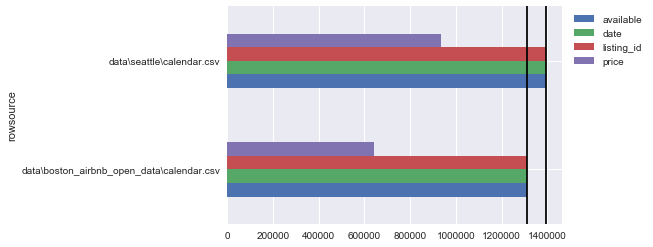

In [6]:
calendar.groupby('rowsource').count().plot.barh();
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left');
for x in calendar.rowsource.value_counts().values:
    plt.vlines(x, -1, 2)

## Relationship Between Nulls Prices and Availability of Listing

In [7]:
calendar.assign(null_price=lambda x: (x.price.apply(type) == float)).groupby(
    ['available', 'null_price']).count()

,,date,listing_id,price,rowsource
available,null_price,,,,
f,True,1124881,1124881,0,1124881
t,False,1577579,1577579,1577579,1577579


**Analysis:** Only price is missing values. However, we can notice that there is a relationship between the null values and the listing not being available. This suggests that all nulls are actually zero values.

# Extracting the Listings Dataset
---

In [8]:
listings = read_concat(folder_names, 'listings.csv')

## Distribution of listings features

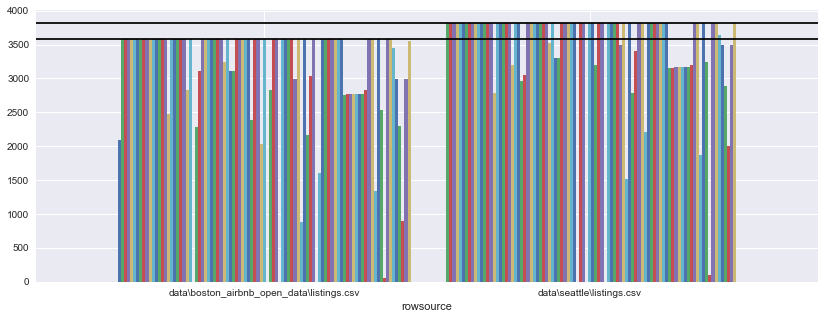

In [9]:
listings.groupby('rowsource').count().plot.bar(
    legend=False, figsize=(14, 5), rot=0, width=.9)
for x in listings.rowsource.value_counts().values:
    plt.hlines(x, -1, 2)

##  Distribution of listings Nulls

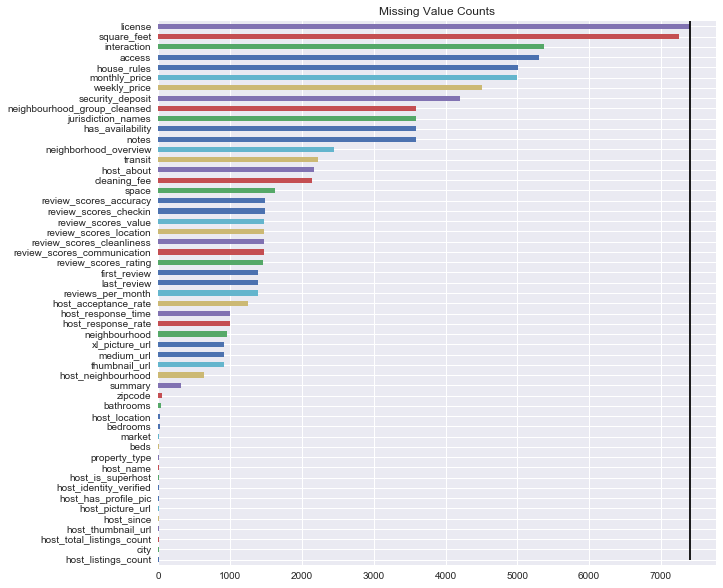

In [10]:
listing_nulls = listings.isnull().sum().where(lambda x: x > 0).dropna(
).sort_values(ascending=True)

listing_nulls.plot.barh(
    figsize=(10, 10), title="Missing Value Counts");
plt.vlines(listings.shape[0], 100, 0);

del listing_nulls

##  Distribution of listing nulls by rowsource and bucket null percentages --RC

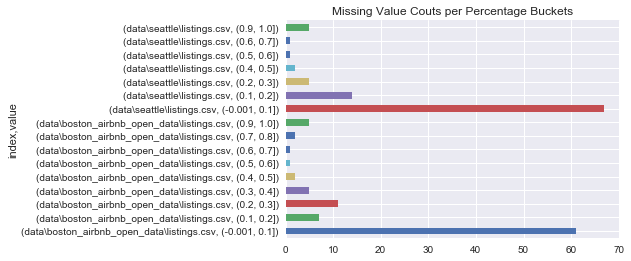

In [11]:
# Total columns by rowsource
totals_byrowsource = listings.rowsource.value_counts()

# Feature totals by rowsource
non_complete_listings = listings.groupby('rowsource').count()

# Feature totals by rowsource - totals, abs
non_complete_listings = non_complete_listings.subtract(totals_byrowsource, axis=0).abs()

# Get percentages of totals per rowsource
non_complete_listings = non_complete_listings.div(totals_byrowsource, axis=0)

# Melt data on rowsource
non_complete_listings = non_complete_listings.reset_index().melt(id_vars='index')

# Grouping by rowsource and provided column buckets
grouping = ['index', pd.cut(non_complete_listings.value, bins=10)]
non_complete_listings = non_complete_listings.groupby(grouping)
non_complete_listings = non_complete_listings.size()
non_complete_listings.plot.barh(title="Missing Value Couts per Percentage Buckets");

In [12]:
listings.isnull().sum().map({
    0: 'Features with fully provided values'
}).fillna('Features with missing values').to_frame('Status').groupby(
    'Status').size()

Status
Features with fully provided values    43
Features with missing values           53
dtype: int64

**Analysis**: We can see that missing values are scattered in this dataset. These missing values need to be investigated  individually and possibly in groups. 

Only 43 features have completed values and 53 of them have missing values.

We can see that **license** and **squared_feet** are completely missing or significantly missing. For this reason we are removing these two features from the dataset and not wasting time analyzing them.

In [13]:
def func_drop_normal(column_list):
    """
    Droping columns from listing without having to write the whole line.
    
    parameter
    ---------
    column_list : column list to removed.
    """
    listings.drop(column_list, axis=1, inplace=True)

In [14]:
remove_cols = ['license', 'square_feet']
func_drop_normal(remove_cols)

# Extracting the Reviews Dataset
---

In [15]:
reviews = read_concat(folder_names, 'reviews.csv')

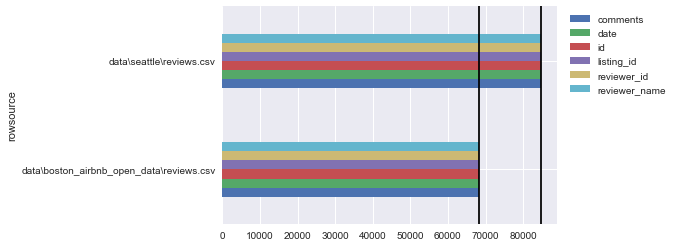

In [16]:
reviews.groupby('rowsource').count().plot.barh();
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left');
for x in reviews.rowsource.value_counts().values:
    plt.vlines(x, -1, 2)

**Analysis**: Simple. Reviews are all complete.

# Understanding Calendar

##  First 5 Rows

In [17]:
calendar.head()

,available,date,listing_id,price,rowsource
0,f,2017-09-05,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
1,f,2017-09-04,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
2,f,2017-09-03,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
3,f,2017-09-02,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
4,f,2017-09-01,12147973,NaN,data\boston_airbnb_open_data\calendar.csv


##  Availability Counts

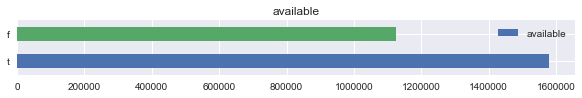

In [18]:
calendar.available.value_counts().plot.barh(
    figsize=(10, 1), title='available', legend=True);

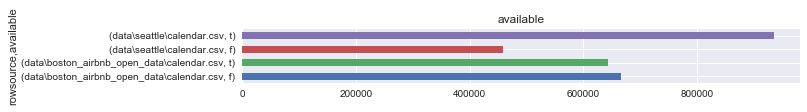

In [19]:
calendar.groupby(['rowsource', 'available']).available.count(
    ).plot.barh(figsize=(10, 1), title='available');

*The Seattle segment have more counts than the boston segment.

##  Price Formats --C

In [20]:
calendar.price.str.findall('\D').value_counts().to_frame('price_counts')

,price_counts
"[$, .]",1574314
"[$, ,, .]",3265


**Analysis**: We will need to clean these invalid characters from the prices.

In [21]:
# Cleaning prices
calendar.price = cleaning_dollar(calendar.price)

# Converting date to datetime
calendar.date = pd.to_datetime(calendar.date)

In [22]:
# Validating cleaning
calendar.price.apply(type).unique()

array([<class 'float'>], dtype=object)

## Price Line Trends by Dataset Source

### Price Trend with Filtered Nulls

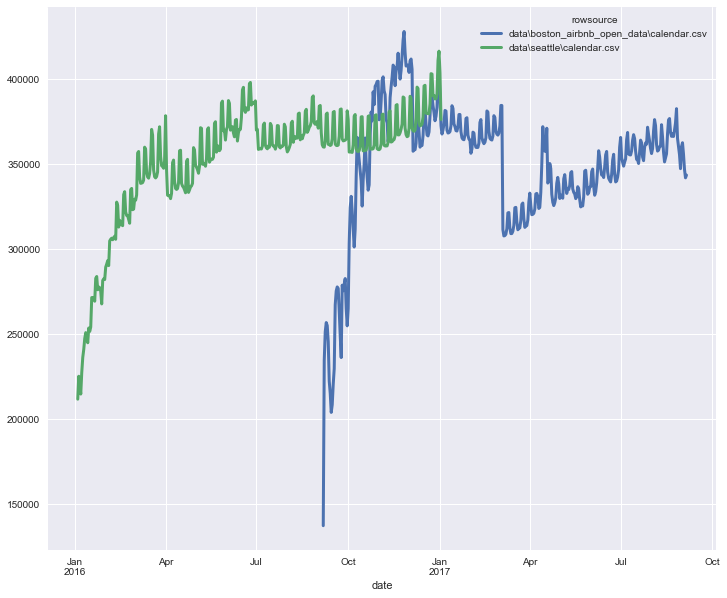

In [23]:
calendar.groupby(['rowsource', 'date'])\
    .agg({'price':'sum'})\
    .reset_index()\
    .pivot(index='date', columns='rowsource', values='price')\
    .plot.line(figsize=(12, 10), lw=3);

* The seattle segment started before the boston segment. Predictions outside each respective ranges could be invalid. Let's keep that in mind.

### Price Trend with Zeroed Nulls

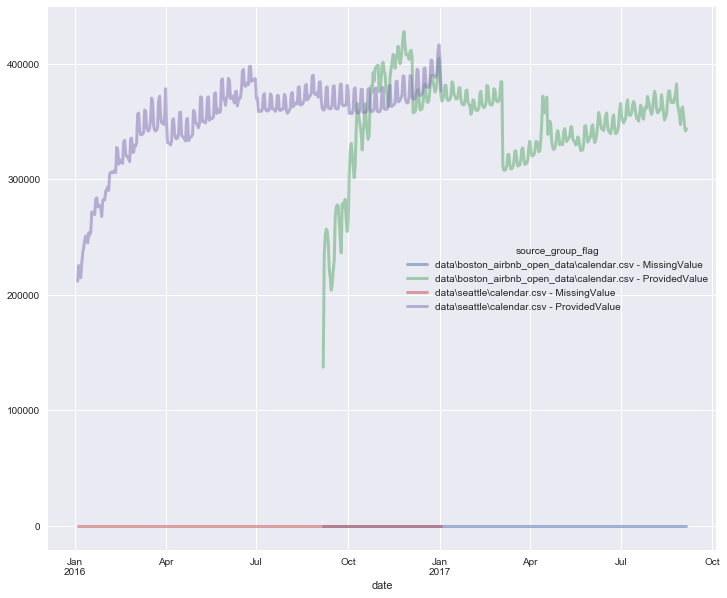

In [24]:
# Grouping missing values and provided values in a flag
calendar['provided_flag'] = calendar.price.fillna('MissingValue')
calendar.loc[calendar.provided_flag!='MissingValue', 'provided_flag'] = 'ProvidedValue'

# Grouping source files with missing values
calendar['source_group_flag'] = calendar.rowsource.str.cat(calendar.provided_flag, sep=' - ')

# Aggregate by source/flag
calendar_grp = calendar.groupby(['source_group_flag', 'date']).agg({'price':'sum'})
calendar_grp = calendar_grp.reset_index()

# Pivot table on source/flag to trend categories
calendar_grp = calendar_grp.pivot(index='date', columns='source_group_flag', values='price')

# Plot
calendar_grp.plot.line(figsize=(12, 10), lw=3, alpha=.5);

* Ranges where there are zero prices cover the whole range per dataset.

## Price Group/Flag Date Ranges

In [25]:
calendar.groupby('source_group_flag').agg({'date': ['min', 'max']})

date           
                                                          min        max
source_group_flag                                                       
data\boston_airbnb_open_data\calendar.csv - Mis... 2016-09-06 2017-09-05
data\boston_airbnb_open_data\calendar.csv - Pro... 2016-09-06 2017-09-05
data\seattle\calendar.csv - MissingValue           2016-01-04 2017-01-02
data\seattle\calendar.csv - ProvidedValue          2016-01-04 2017-01-02

## Difference Between Data Source Pricing Dates

In [26]:
# Month tranformation functions
month_func = lambda x: x.month
delta_month_func = lambda x: x.max_date.shift(1).apply(
    month_func) - x.max_date.apply(month_func)
delta_days_func = lambda x: x.max_date.shift(1) - x.max_date

calendar.groupby('rowsource').agg({
    'date': 'max'
}).rename(columns={
    'date': 'max_date'
}).assign(
    delta_month=delta_month_func, delta_days=delta_days_func).fillna('')

,max_date,delta_month,delta_days
rowsource,,,
data\boston_airbnb_open_data\calendar.csv,2017-09-05,,
data\seattle\calendar.csv,2017-01-02,8,246 days 00:00:00


**Analysis** We can see that there is more availability in Seattle listings. The total monthly trend prices are quite similar for both datasets. And the null values are scattered all within the min and max pricing dates. We are going to investigate these nulls during the listing null analysis.

Dates of datasets do not match. This could mean that these segments were serviced at different times. ARBNB must have started servicing Seattle before Boston. However, Seattle has no data from 2017-01-02 to 2017-09-05, 8 months or 246 days. Therefore, as a warning prediction using Seattle during these ranges will be incorrect. The same applies to Boston.

# Understanding Listings
---

## Analyzing Object Features of Listings

In [27]:
# Calculating missing percentages of total listings
missing_pct = listings.isnull().sum() / listings.shape[0]

# Listings examples with missing percentages
pd.options.display.max_rows = 100

listings.select_dtypes(include=object).dropna(
    axis=0, how='all').sample(1).T.merge(
        missing_pct.to_frame('missing'),
        left_index=True,
        right_index=True,
        how='left').iloc[:, [1, 0]].sort_values(
            'missing', ascending=False).style.bar()

,missing,4278
interaction,0.725652,nan
access,0.716872,nan
house_rules,0.676753,nan
monthly_price,0.675132,nan
weekly_price,0.608132,nan
security_deposit,0.566662,nan
jurisdiction_names,0.484263,WASHINGTON
neighbourhood_group_cleansed,0.484263,University District
has_availability,0.484263,t
notes,0.483723,nan


## Analying Numeric Features of Listings

In [28]:
listings.filter(regex='id')
listings.select_dtypes(exclude=object).sample(4).T.merge(
    missing_pct.to_frame('missing'),
    left_index=True,
    right_index=True,
    how='left').iloc[:, [-1, 0, 1, 2, 3]].sort_values(
        'missing',
        ascending=False).style.format("{:2,.2f}").bar(subset=['missing'])

,missing,6752,5330,1701,1786
review_scores_accuracy,0.20,10.00,10.00,nan,nan
review_scores_checkin,0.20,10.00,9.00,nan,nan
review_scores_value,0.20,10.00,10.00,nan,nan
review_scores_location,0.20,10.00,10.00,nan,nan
review_scores_cleanliness,0.20,10.00,10.00,nan,nan
review_scores_communication,0.20,10.00,10.00,nan,nan
review_scores_rating,0.20,96.00,97.00,nan,nan
reviews_per_month,0.19,4.15,0.23,nan,nan
bathrooms,0.00,1.00,1.50,1.00,2.00
bedrooms,0.00,1.00,3.00,1.00,2.00


## Analyzing Date Features of Listings --RC

In [29]:
listings.select_dtypes(include=object)\
    .apply(pd.to_datetime, errors='ignore')\
    .select_dtypes(include=np.datetime64).head()

,calendar_last_scraped,first_review,host_since,last_review,last_scraped
0,2016-09-06,NaT,2015-04-15,NaT,2016-09-07
1,2016-09-06,2014-06-01,2012-06-07,2016-08-13,2016-09-07
2,2016-09-06,2009-07-19,2009-05-11,2016-08-05,2016-09-07
3,2016-09-06,2016-08-28,2013-04-21,2016-08-28,2016-09-07
4,2016-09-06,2015-08-18,2014-05-11,2016-09-01,2016-09-07


In [30]:
listings['last_scraped'].unique()

array(['2016-09-07', '2016-01-04'], dtype=object)

**Analysis**: We can see that we have to do some imputations on the reviews for the numerical fields. For the object fields, there are some numerical values that will have to be cleaned and some irrelevant columns such as URLs and names. One thing to notice is that **amenities** and **host_verification** can be split and converted to dummy variables. These could be helpful to the model.

Perhaps the **calendar_last_scraped** feature has a meaningful link to the dataset. The other dates (**first_review, host_since, and last_review**) could be used to engineer new features. Only **last_scraped** seems to be irrelevant in this case since it only describes the date the datasets where extracted.

In [31]:
func_drop_normal('last_scraped')

# Uderstanding Reviews

##  Frist 5 Rows

In [32]:
reviews.head()

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource
0,My stay at islam's place was really cool! Good...,2013-05-21,4724140,1178162,4298113,Olivier,data\boston_airbnb_open_data\reviews.csv
1,Great location for both airport and city - gre...,2013-05-29,4869189,1178162,6452964,Charlotte,data\boston_airbnb_open_data\reviews.csv
2,We really enjoyed our stay at Islams house. Fr...,2013-06-06,5003196,1178162,6449554,Sebastian,data\boston_airbnb_open_data\reviews.csv
3,The room was nice and clean and so were the co...,2013-06-15,5150351,1178162,2215611,Marine,data\boston_airbnb_open_data\reviews.csv
4,Great location. Just 5 mins walk from the Airp...,2013-06-16,5171140,1178162,6848427,Andrew,data\boston_airbnb_open_data\reviews.csv


## Id Relationships Lenght Box Plots

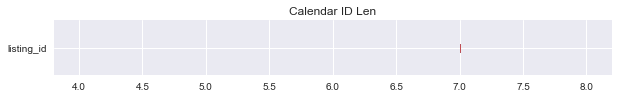

In [33]:
calendar.listing_id.astype(str).str.len()\
    .plot.box(vert=False, figsize=(10, 1), title="Calendar ID Len");

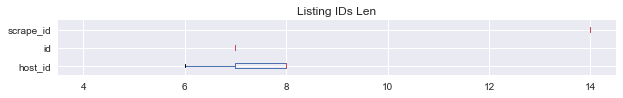

In [34]:
len_func = lambda x: x.str.len()

listings.filter(regex='id').select_dtypes(exclude=object).astype(str).apply(len_func)\
    .plot.box(vert=False, figsize=(10, 1), title="Listing IDs Len");

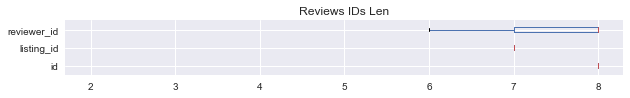

In [35]:
reviews.filter(regex='id').apply(lambda x: x.astype(str).str.len())\
    .plot.box(vert=False, figsize=(10, 1), title="Reviews IDs Len");

**Analysis**: We can surely see these are just individual reviews for the listings. Given that there are reviewer-ids with a length of 2 and 3 in the reviewers dataset and not in the listings dataset, we can assume that the listings don't include stays (missing records) for those host with 2 and 3 length-ids, but those hosts have reviews for the listings in the reviewer dataset.

* The listing dataset id is the primary key that relates to the listing_id of the calendar dataset.
* The scrape_id does not relate to anything in the downloaded dataset, so, therefore, it is irrelevant for the analysis. However, this id could be related to the calendar date since it could mean that the data was scraped during a specific calendar date.
* The host_id in the listing dataset seems to be related to the reviewer_id of the reviews dataset.

# Calendar Granularity

## Calendar Duplicates

In [36]:
calendar_dup = calendar.groupby(
    ['date', 'listing_id', 'rowsource',
     'available']).size().to_frame('duplicates').query("duplicates>1")
calendar_dup.head()

,,,,duplicates
date,listing_id,rowsource,available,
2016-09-06,12898806,data\boston_airbnb_open_data\calendar.csv,t,2
2016-09-07,12898806,data\boston_airbnb_open_data\calendar.csv,t,2
2016-09-08,12898806,data\boston_airbnb_open_data\calendar.csv,t,2
2016-09-09,12898806,data\boston_airbnb_open_data\calendar.csv,t,2
2016-09-10,12898806,data\boston_airbnb_open_data\calendar.csv,t,2


In [37]:
calendar_price_dups = calendar_dup.reset_index().listing_id.unique()[0]
print(f"These are the id of price duplicates: \n {calendar_price_dups}")

These are the id of price duplicates: 
 12898806


### Examples of Calendar Duplicates --RR

In [38]:
# Conditions
date_dup = calendar_dup.reset_index().date.astype(str).values.tolist()
date_filter = calendar.date.astype(
    str).apply(lambda x: True if x in date_dup else False)
filter_cond = (calendar.listing_id == 12898806) & date_filter

# Duplicate Examples
calendar.loc[filter_cond, :].sort_values(['date', 'listing_id']).head()

,available,date,listing_id,price,rowsource,provided_flag,source_group_flag
748850,t,2016-09-06,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748873,t,2016-09-06,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748849,t,2016-09-07,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748872,t,2016-09-07,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748848,t,2016-09-08,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...


**Analysis**: There are 365 duplicates in the calendar dataset. These duplicates can be safely removed since they all share the same information. It does not really matter if we keep the first or last. We are removing these duplicates.

The granularity of the table is at the following level:
* Date
* Listing Id

In [39]:
# Flag where there are no duplicates
keep_first = ~calendar.duplicated(subset=['date', 'listing_id'], keep='last')

# Remove duplicates by slicing
calendar_clean = calendar[keep_first]

# Calculate the difference beteween sizes
dup_count = calendar_dup.count().values[0]
dup_removed = calendar.shape[0] - calendar_clean.shape[0]

print(f"There where {dup_count} duplicates and {dup_removed} where removed.")

There where 365 duplicates and 365 where removed.


# Listings Granularity

## First 5 Rows

In [40]:
listings.head()

,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,...,smart_location,space,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
0,"You will have access to 2 bedrooms, a living r...",4,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",0,0,0,0,1.5,Real Bed,2.0,...,"Boston, MA",The house has an open and cozy feel at the sam...,MA,"Birch Street, Boston, MA 02131, United States","Cozy, sunny, family home. Master bedroom high...",https://a2.muscache.com/im/pictures/c0842db1-e...,"The bus stop is 2 blocks away, and frequent. B...",NaN,https://a2.muscache.com/im/pictures/c0842db1-e...,02131
1,Apt has one more bedroom (which I use) and lar...,2,"{TV,Internet,""Wireless Internet"",""Air Conditio...",26,359,54,84,1.0,Real Bed,1.0,...,"Boston, MA",Small but cozy and quite room with a full size...,MA,"Pinehurst Street, Boston, MA 02131, United States",Charming and quiet room in a second floor 1910...,https://a1.muscache.com/im/pictures/39327812/d...,Plenty of safe street parking. Bus stops a few...,$400.00,https://a1.muscache.com/im/pictures/39327812/d...,02131
2,"I am living in the apartment during your stay,...",2,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",19,319,46,61,1.0,Real Bed,1.0,...,"Boston, MA","Come stay with a friendly, middle-aged guy in ...",MA,"Ardale St., Boston, MA 02131, United States","Come stay with a friendly, middle-aged guy in ...",https://a2.muscache.com/im/pictures/6ae8335d-9...,"PUBLIC TRANSPORTATION: From the house, quick p...",$395.00,https://a2.muscache.com/im/pictures/6ae8335d-9...,02131
3,The basement has a washer dryer and gym area. ...,4,"{TV,Internet,""Wireless Internet"",""Air Conditio...",6,98,16,26,1.0,Real Bed,1.0,...,"Boston, MA",Most places you find in Boston are small howev...,MA,"Boston, MA, United States",Come experience the comforts of home away from...,https://a2.muscache.com/im/pictures/39764190-1...,There are buses that stop right in front of th...,NaN,https://a2.muscache.com/im/pictures/39764190-1...,NaN
4,You will have access to the front and side por...,2,"{Internet,""Wireless Internet"",""Air Conditionin...",13,334,34,59,1.5,Real Bed,1.0,...,"Boston, MA","Clean, attractive, private room, one block fro...",MA,"Durnell Avenue, Boston, MA 02131, United States","My comfy, clean and relaxing home is one block...",https://a1.muscache.com/im/pictures/97154760/8...,From Logan Airport and South Station you have...,NaN,https://a1.muscache.com/im/pictures/97154760/8...,02131


## Listings Duplicates

In [41]:
listings.groupby(['id']).size().to_frame('duplicates').query("duplicates>1")

,duplicates
id,


**Analysis**: Plain and simple, there are no duplicates in this dataset. Great!

The granularity is at the id level. All other features are aggregates or normalized records.

# Reviews Granularity

## First 5 Rows

In [42]:
reviews.head()

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource
0,My stay at islam's place was really cool! Good...,2013-05-21,4724140,1178162,4298113,Olivier,data\boston_airbnb_open_data\reviews.csv
1,Great location for both airport and city - gre...,2013-05-29,4869189,1178162,6452964,Charlotte,data\boston_airbnb_open_data\reviews.csv
2,We really enjoyed our stay at Islams house. Fr...,2013-06-06,5003196,1178162,6449554,Sebastian,data\boston_airbnb_open_data\reviews.csv
3,The room was nice and clean and so were the co...,2013-06-15,5150351,1178162,2215611,Marine,data\boston_airbnb_open_data\reviews.csv
4,Great location. Just 5 mins walk from the Airp...,2013-06-16,5171140,1178162,6848427,Andrew,data\boston_airbnb_open_data\reviews.csv


## Reviews Duplicates

In [43]:
reviews.groupby(['listing_id', 'reviewer_id', 'date',
                 'id']).size().to_frame('duplicates').query("duplicates>1")

,,,,duplicates
listing_id,reviewer_id,date,id,


In [44]:
reviews.groupby(['id']).size().to_frame('duplicates').query("duplicates>1")

,duplicates
id,


## Multiple Comments by Reviewer Relating to Listings

In [45]:
reviews_duplicated = reviews.groupby([
    'listing_id', 'reviewer_id', 'date'
]).size().to_frame("duplicates").query("duplicates>1").reset_index()
reviews_duplicated.style.bar(subset=['duplicates'])

,listing_id,reviewer_id,date,duplicates
0,447523,35607120,2015-07-06,2
1,568234,16199611,2014-09-08,2
2,1173306,8492099,2013-09-06,2
3,1529321,30877683,2015-05-15,2
4,3533224,39668556,2015-12-01,2
5,3866526,63239764,2016-03-18,2
6,3897963,47193495,2016-04-07,2
7,3897995,39441871,2016-03-23,2
8,3901439,9618964,2016-03-24,2
9,4402209,63239764,2016-03-25,2


### Examples of Multiple Reviews per Listing

In [46]:
reviews.merge(reviews_duplicated.drop('duplicates', axis=1),
              on=['listing_id', 'reviewer_id', 'date'], 
              how='left',
              indicator=True)\
    .query("_merge=='both'").head(6)\
    .style.background_gradient(subset=['reviewer_id'])

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource,_merge
6558,Nice neighborhood with a lot of local life and restaurants. Check in was simple and I was never bothered.,2015-05-15,32216803,1529321,30877683,Jonathan,data\boston_airbnb_open_data\reviews.csv,both
6559,"A+ treatment all the way, you are an adult in a friendly part of town. Nice room and choice of two bathrooms.",2015-05-15,32223055,1529321,30877683,Jonathan,data\boston_airbnb_open_data\reviews.csv,both
29370,The reservation was canceled 23 days before arrival. This is an automated posting.,2014-09-08,19256952,568234,16199611,Lyn,data\boston_airbnb_open_data\reviews.csv,both
29371,The reservation was canceled 24 days before arrival. This is an automated posting.,2014-09-08,19256954,568234,16199611,Lyn,data\boston_airbnb_open_data\reviews.csv,both
30826,My night at Aris house was perfect yet again! Thank you so much for hosting me Ari!!,2016-03-25,66858887,4402209,63239764,Sandiya,data\boston_airbnb_open_data\reviews.csv,both
30827,"The hosts communication was great, the listing was exactly as described definitely stay at Aris house if you need a place in Boston.",2016-03-25,66963792,4402209,63239764,Sandiya,data\boston_airbnb_open_data\reviews.csv,both


**Analysis**: This dataset has no duplicates as well as listings. 

The granularity of the dataset is also at the id level. In this case the review id.

However, as it relates to listings, there are several reviews for the same listing during the same date. Some of them have automated comments that could be impacting the overall listing reviews.

* Granulated at the listing_id, reviewer_id, and date level.
* Some duplicates by automation. 
* Some manual duplicates by reviewer with different commets for same date and listing.

# Testing Relationships beteween Datasets

## Relationship between Geo Columns

In [47]:
# Get geo columns
geo_columns = listings.select_dtypes(include=object).columns[-10:][:-6].tolist()

listings[geo_columns].head()

,smart_location,space,state,street
0,"Boston, MA",The house has an open and cozy feel at the sam...,MA,"Birch Street, Boston, MA 02131, United States"
1,"Boston, MA",Small but cozy and quite room with a full size...,MA,"Pinehurst Street, Boston, MA 02131, United States"
2,"Boston, MA","Come stay with a friendly, middle-aged guy in ...",MA,"Ardale St., Boston, MA 02131, United States"
3,"Boston, MA",Most places you find in Boston are small howev...,MA,"Boston, MA, United States"
4,"Boston, MA","Clean, attractive, private room, one block fro...",MA,"Durnell Avenue, Boston, MA 02131, United States"


* space and street are too long for this analysis

In [48]:
# Removing long features
geo_columns.remove('space')
geo_columns.remove('street')

In [51]:
# Mergin clean calendar with listings
airbnb_geo_test = calendar_clean.merge(
    listings[['id'] + geo_columns],
    left_on='listing_id',
    right_on='id',
    how='left',
    suffixes=['', '_list'],
    indicator=True)

In [54]:
airbnb_geo_test.rowsource.value_counts()

data\seattle\calendar.csv                    1393570
data\boston_airbnb_open_data\calendar.csv    1308525
Name: rowsource, dtype: int64

In [55]:
calendar_clean.rowsource.value_counts()

data\seattle\calendar.csv                    1393570
data\boston_airbnb_open_data\calendar.csv    1308525
Name: rowsource, dtype: int64

In [56]:
airbnb_geo_test._merge.value_counts()

both          2702095
right_only          0
left_only           0
Name: _merge, dtype: int64

In [57]:
airbnb_geo_test.groupby(['state', 'rowsource']).size()

state  rowsource                                
MA     data\boston_airbnb_open_data\calendar.csv    1308525
WA     data\seattle\calendar.csv                    1393205
wa     data\seattle\calendar.csv                        365
dtype: int64

In [58]:
del airbnb_geo_test

**Analysis**: We can see that the calendar dataset has full relationship with listing, which is excactly what we need. This means that all calendar listings_ids have relationships with listings ids.

The merge worked, perfectly matching state and rowsource.

## Looking for Meaningful Relationship Between Listing and Reivews

### Assessing Reviews and Ids from Sample

In [59]:
# Assessing duplicate id in listings again
print("There are" , 
      listings.id.value_counts().where(lambda x: x>1).sum(),
      "dupliate ids in the listing dataset.")

There are 0.0 dupliate ids in the listing dataset.


In [60]:
airbnb_review_test = listings.merge(
    reviews, 
    left_on='id', 
    right_on='listing_id', 
    how='left', 
    suffixes=['', '_review'],
    indicator=True)

In [61]:
airbnb_review_test.groupby(['state', 'rowsource_review']).size()

state  rowsource_review                        
MA     data\boston_airbnb_open_data\reviews.csv    68275
WA     data\seattle\reviews.csv                    84849
dtype: int64

In [62]:
listings.groupby(['state', 'rowsource']).size()

state  rowsource                                
MA     data\boston_airbnb_open_data\listings.csv    3585
WA     data\seattle\listings.csv                    3817
wa     data\seattle\listings.csv                       1
dtype: int64

*We can see that reviews will have to be aggregated before joining to listings. But we will take care of that if it is necessary.

### Descriptive Statistics About Comments

In [63]:
comment_listing_counts = reviews.groupby('listing_id').size().to_frame(
    'comment_count').groupby('comment_count').size().reset_index().rename(
        columns={0: 'total_unique_listing_ids'})

comment_listing_counts[['comment_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
comment_count,229.0,127.720524,88.54982,1.0,58.0,115.0,180.0,474.0


In [64]:
comment_listing_counts.groupby(
    pd.cut(comment_listing_counts.comment_count,
           bins=list(np.arange(0, 550, 50)))).sum()[[
               'total_unique_listing_ids'
           ]].reset_index().set_index('total_unique_listing_ids').rename(
               columns={'comment_count': 'comment_count_buckets'})

,comment_count_buckets
total_unique_listing_ids,
5157,"(0, 50]"
570,"(50, 100]"
167,"(100, 150]"
73,"(150, 200]"
28,"(200, 250]"
16,"(250, 300]"
4,"(300, 350]"
1,"(350, 400]"
2,"(400, 450]"


*We can see that most listings have from 1 to 50 comments to apply natural language processing to predict ratings in the listing dataset if needed.

## Relationship betwee Datasets Results

**Analysis**: The datasets agree on the state and the source file name. The join between dataset is valid.

The relationship between listing dataset reviews and reviews dataset comments is by the listing_id there are at most 474 reviews on at least one listing. Two listings have around 451 to 474 comments. However, the majority of the listings have 1 to 50 comments. So for some listing_ids predicting ratings might be difficult due to sparsity. 

The join for the final dataset is as follows:
* listing_id on calendar
* id on listings
* inner join on calendar side

# Preparing Data for Analysis --T

In [65]:
# column additions for scatter and monthly comparisons
calendar_clean = calendar_clean.assign(date_num=lambda x: x.date.rank(method='dense'))

In [66]:
# Get the month name
lmfunc_concat_name = lambda x: f"{x.month:02d}" + '-' + x.month_name() 
lmfunc_month_name = lambda x: x.date.apply(lmfunc_concat_name)

calendar_clean =  calendar_clean.assign(month_name=lmfunc_month_name)

## Calendar Removals or Imputations

###  Assessing Calendar Removal Impact

In [67]:
data_formats = {'row_count':'{:2,.0f}', 'pct_total':'{:2.2%}'}

calendar_missing = calendar_clean.groupby('provided_flag').size().to_frame('row_count')\
        .assign(pct_total=lambda x: x.row_count/x.row_count.sum())

calendar_missing.style.format(data_formats)

,row_count,pct_total
provided_flag,,
MissingValue,"1,124,596",41.62%
ProvidedValue,"1,577,499",58.38%


### Removal Percentages by Data Source

In [68]:
calendar_rowsource_miss = calendar_clean.groupby(
    ['rowsource', 'provided_flag']).size().to_frame('row_count').assign(
        pct_total=lambda x: x.row_count / x.row_count.sum())

calendar_rowsource_miss.style.format(data_formats)

### Removals by Month

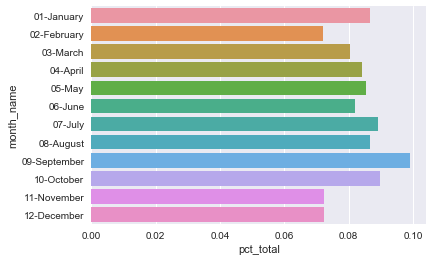

In [69]:
calendar_month_miss = calendar_clean.query("provided_flag=='MissingValue'").groupby(
    ['month_name', 'provided_flag']).size().to_frame('row_count').assign(
        pct_total=lambda x: x.row_count / x.row_count.sum())

sns.barplot(
    x='pct_total', y='month_name', data=calendar_month_miss.reset_index());

### Price Distributions by Month, RowSource, Dates

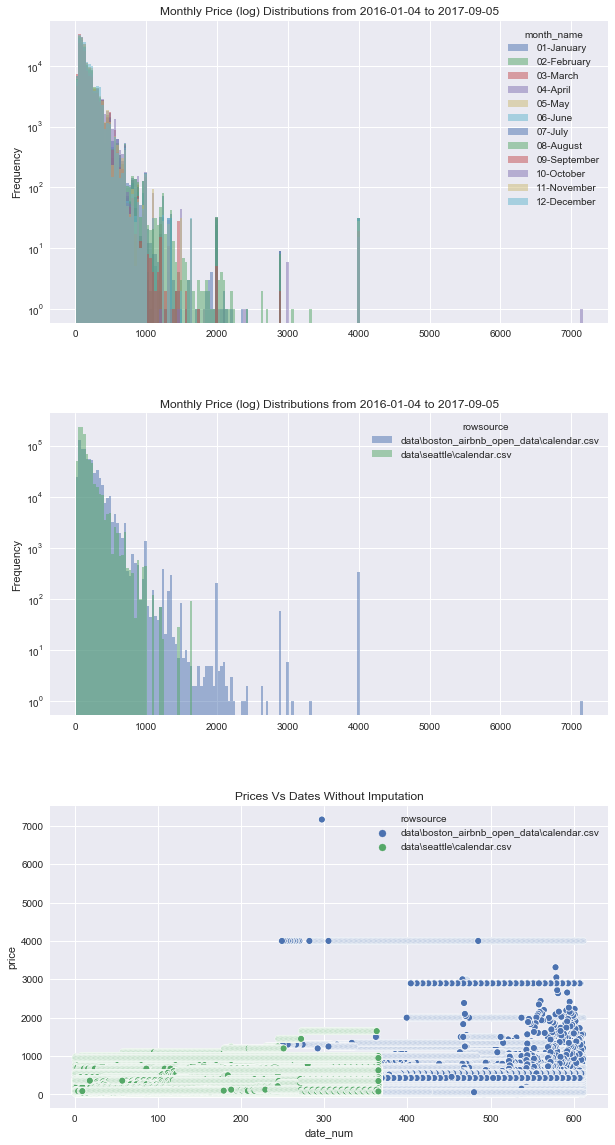

In [70]:
# Dataset groupings
calendar_price_bymonth = calendar_clean.reset_index(drop=True).pivot(
    columns='month_name', values='price')

calendar_price_bysource = calendar_clean.reset_index(drop=True)\
    .pivot(columns='rowsource', values='price')

# Title min max dates
max_date = str(calendar_clean.date.max().date())
min_date = str(calendar_clean.date.min().date())

# Starting subplot
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

plt.subplots_adjust(hspace=.3)

calendar_price_bymonth.plot.hist(
    bins=200,
    logy=True,
    alpha=.5,
    title=f'Monthly Price (log) Distributions from {min_date} to {max_date}',
    ax=ax[0])

calendar_price_bysource.plot.hist(
    bins=200,
    logy=True,
    alpha=.5,
    title=f'Monthly Price (log) Distributions from {min_date} to {max_date}', ax=ax[1])

plt.title('Prices Vs Dates Without Imputation')
sns.scatterplot(x='date_num', 
                y='price', 
                hue='rowsource', 
                data=calendar_clean, ax=ax[2])

plt.show()

### Price Relation with Availabity --RR

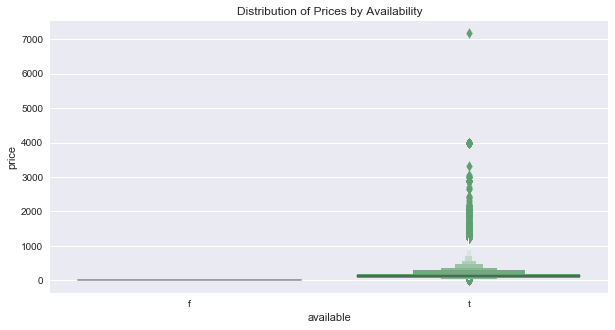

In [71]:
plt.figure(figsize=(10, 5))
plt.title("Distribution of Prices by Availability")
sns.boxenplot(
    x='available', y='price', data=calendar_clean.fillna(0));

**Analysis**: Simply removing all null prices will remove 41.62% of the calendar data. Most of it will be from the Boston dataset. However, missing prices are related to unavailable listings or available = f (for False).

As much as we want to prevent such drastic removals, we cannot do imputations for these nulls. We want to predict prices of listings and it is obvious that prices for unavailable listings are 0. For this reason, we are removing any null prices or all unavailable listings.

In [72]:
# Validator
available_count = calendar_clean.query("available=='t'").shape[0]
print(f"There are {available_count:2,.0f} available listings in the calendar dataset.")

# Removing all Nulls
calendar_removals = calendar_clean.dropna()

# Validating
kept_count = calendar_removals.shape[0]
print(f"There are {kept_count:2,.0f} listings in the calendar dataset after removals.")

There are 1,577,499 available listings in the calendar dataset.
There are 1,577,499 listings in the calendar dataset after removals.


### Removing Other Irrelevant Columns --RC

In [73]:
# Save date and date number for reference
date_references = calendar_removals[['date', 'date_num']]

In [74]:
drop_columns = ['available', 'rowsource', 'provided_flag', 
                'source_group_flag', 'month_name', 'date']

# Removing non-predictors
try: calendar_removals = calendar_removals.drop(drop_columns, axis=1)
except: pass

### Finishing the Calendar Data Preparation and Releasing Objects from Memory

In [75]:
# Copy calendar removals to the completed calendar
try:
    calendar_complete = calendar_removals.copy()
except:
    pass

del calendar_clean, 
del calendar_removals, 
del calendar_dup, 
del calendar_grp,
del calendar_missing, 
del calendar_month_miss, 
del calendar_price_bymonth,
del calendar_price_bysource, 
del calendar_rowsource_miss
del calendar_price_dups

calendar_complete.head()

,listing_id,price,date_num
365,3075044,65.0,597.0
366,3075044,65.0,596.0
367,3075044,65.0,595.0
368,3075044,75.0,594.0
369,3075044,75.0,593.0


### Checking Correlations of Final Calendar

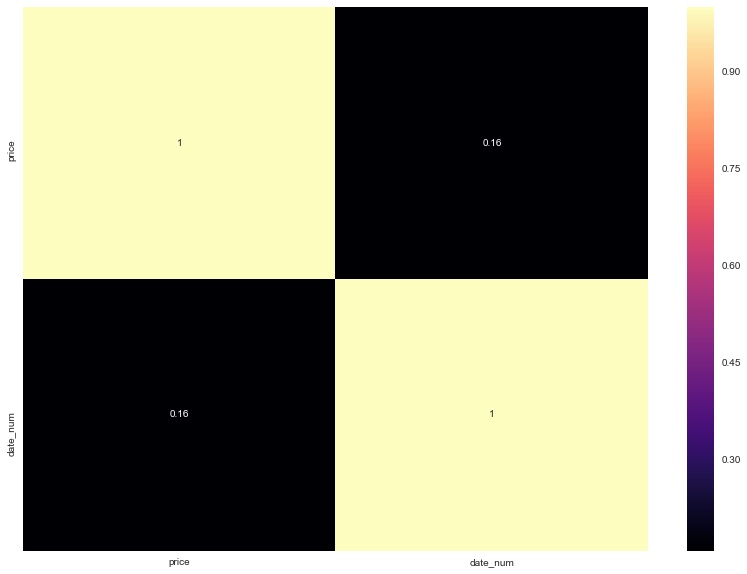

In [76]:
analysis = AnalysisStatus(calendar_complete, listings)
analysis.correlation_heatmap(['date_num'])

Good. Alone with price, the date number has at least a low correlation with price, which means that there is  $𝑟^2$  percentage of explenation by daily movements. The rest can be attributed to other features that we are going to explore next.

## Listing Removals or Imputations

### Listings Null Analysis

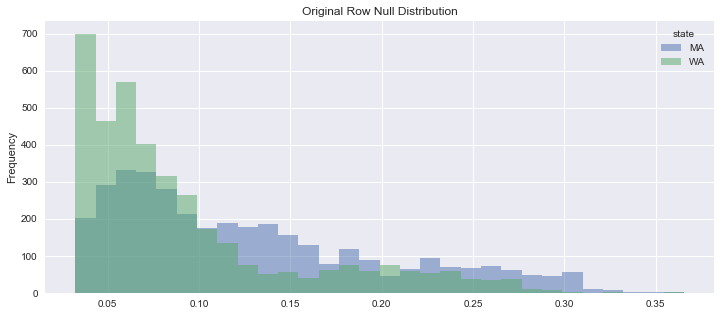

In [77]:
analysis.null_row_listingdist(30, 'Original Row Null Distribution')               

We are not observing an alarming rate of rows with null values across it. However, some of these features might be irrelevant for the analysis, and we should remove them. There could be other variables that can be impute. We will assess this distribution again after removals and imputations.

### Identifying Irrelevant Columns

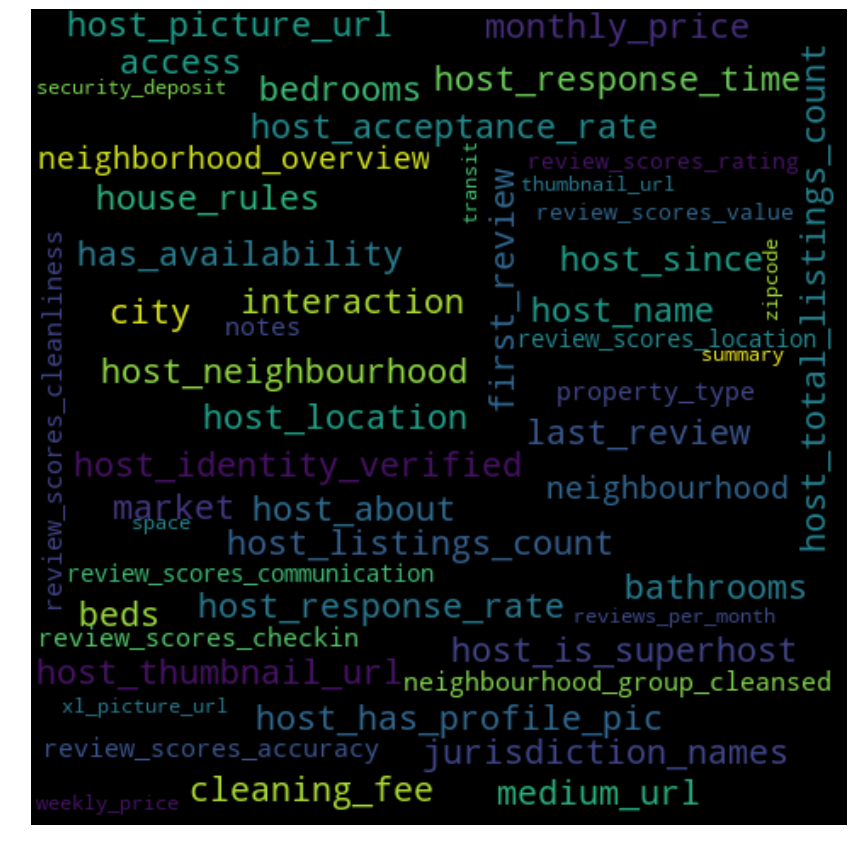

In [78]:
# target colmuns for imputations and transformations
target_columns = listings.isnull().sum().where(lambda x: x>0).dropna().index.tolist()
target_columns = ' '.join(target_columns)
target_columns

wordcloud = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10).generate(target_columns)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


All of these features in the wordcloud need to be analyized for null relations to other feature values. But some of theme are irrelevant for the analysis such as those that finish with url.

### Columns to Remove due to Irrelevance

In [79]:
# Irrelevant columns
irrelevant_columns = listings.columns.str.contains('url|name|about|pic')
irrelevant_columns = listings.columns[irrelevant_columns].tolist()

# Show irrelevant features
listings[irrelevant_columns].head(1).T.style.set_caption("Irrelevant Features")

,0
host_about,"We are country and city connecting in our deck and garden. Enjoy our music room, books and flat screen TV with the pastoral backyard of hens, bees, rabbits and an organic garden."
host_has_profile_pic,t
host_name,Virginia
host_picture_url,https://a2.muscache.com/im/pictures/5936fef0-ba16-45bd-ac33-9226137d0763.jpg?aki_policy=profile_x_medium
host_thumbnail_url,https://a2.muscache.com/im/pictures/5936fef0-ba16-45bd-ac33-9226137d0763.jpg?aki_policy=profile_small
host_url,https://www.airbnb.com/users/show/31303940
jurisdiction_names,nan
listing_url,https://www.airbnb.com/rooms/12147973
medium_url,https://a2.muscache.com/im/pictures/c0842db1-ee98-4fe8-870b-d1e2af33855d.jpg?aki_policy=medium
name,Sunny Bungalow in the City


These, above, are irrelevant columns since they describe web addresses and names. So there is no value to them in a regression analysis. 

On the contrary **host_has_profile_pic** and **require_guest_profile_picture** might add value to the model.

### Null Row Values Exceeding 10%

In [80]:
analysis.null_row_feature_status(percentages=True, threshold=.10)

interaction                     0.725652
access                          0.716872
house_rules                     0.676753
monthly_price                   0.675132
weekly_price                    0.608132
security_deposit                0.566662
neighbourhood_group_cleansed    0.484263
has_availability                0.484263
jurisdiction_names              0.484263
notes                           0.483723
neighborhood_overview           0.330542
transit                         0.300419
host_about                      0.292854
cleaning_fee                    0.288667
space                           0.219641
review_scores_accuracy          0.200054
review_scores_checkin           0.199649
review_scores_value             0.199514
review_scores_location          0.199514
review_scores_cleanliness       0.198703
review_scores_communication     0.198433
review_scores_rating            0.197217
reviews_per_month               0.186816
first_review                    0.186816
last_review     

### Assessing Transformations of Informational Features

#### Examples of Informational Columns with Missing Values --T

In [81]:
interest = ['']
iform_arguments = 'access|over|rule|notes|space|summary|transit|interaction|host_about|desc'
inform_columns = listings.filter(regex=iform_arguments).columns.tolist()
listings[inform_columns].head()

,access,description,host_about,house_rules,interaction,neighborhood_overview,notes,space,summary,transit
0,"You will have access to 2 bedrooms, a living r...","Cozy, sunny, family home. Master bedroom high...",We are country and city connecting in our deck...,Clean up and treat the home the way you'd like...,NaN,"Roslindale is quiet, convenient and friendly. ...",NaN,The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...","The bus stop is 2 blocks away, and frequent. B..."
1,Apt has one more bedroom (which I use) and lar...,Charming and quiet room in a second floor 1910...,I live in Boston and I like to travel and have...,Pet friendly but please confirm with me if the...,"If I am at home, I am likely working in my hom...","The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,Plenty of safe street parking. Bus stops a few...
2,"I am living in the apartment during your stay,...","Come stay with a friendly, middle-aged guy in ...","I am a middle-aged, single male with a wide ra...","I encourage you to use my kitchen, cooking and...","ABOUT ME: I'm a laid-back, friendly, unmarried...",The LOCATION: Roslindale is a safe and diverse...,I am in a scenic part of Boston with a couple ...,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","PUBLIC TRANSPORTATION: From the house, quick p..."
3,The basement has a washer dryer and gym area. ...,Come experience the comforts of home away from...,My husband and I live on the property. He’s a...,- The bathroom and house are shared so please ...,We do live in the house therefore might be som...,Roslindale is a lovely little neighborhood loc...,Please be mindful of the property as it is old...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,There are buses that stop right in front of th...
4,You will have access to the front and side por...,"My comfy, clean and relaxing home is one block...",I work full time for a public school district....,"Please no smoking in the house, porch or on th...",I love my city and really enjoy sharing it wit...,"I love the proximity to downtown, the neighbor...",I have one roommate who lives on the lower lev...,"Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",From Logan Airport and South Station you have...


In [82]:
# Values with 1 should match this
listings[inform_columns].isnull().sum()

access                   5307
description                 0
host_about               2168
house_rules              5010
interaction              5372
neighborhood_overview    2447
notes                    3581
space                    1626
summary                   320
transit                  2224
dtype: int64

*We are validating informational transformations to these null value counts.

In [294]:
# listings checkpoint
listings_transform = listings.copy()

In [295]:
# Conducting Transformations and Imputations
provided_func = lambda x: x.isnull()
inform_transform = listings_transform[inform_columns].where(provided_func, 0).fillna(1)

# creating the new column for provided access information
listings_transform.loc[:, inform_columns] = inform_transform

In [296]:
# Matching 1 to provided information
listings_transform[inform_columns].sum()

access                   5307
description                 0
host_about               2168
house_rules              5010
interaction              5372
neighborhood_overview    2447
notes                    3581
space                    1626
summary                   320
transit                  2224
dtype: int64

*Tranformation checks out.

#### Checking Correlations of Informational Features

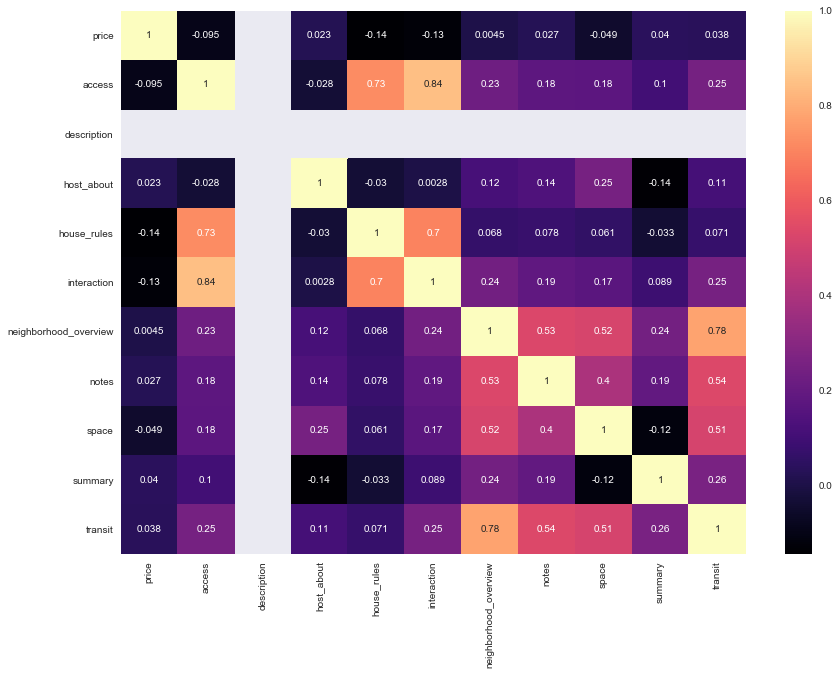

In [297]:
analysis = AnalysisStatus(calendar_complete, listings_transform)
analysis.correlation_heatmap(inform_columns)

#### Checking Null Distributions After Transformations

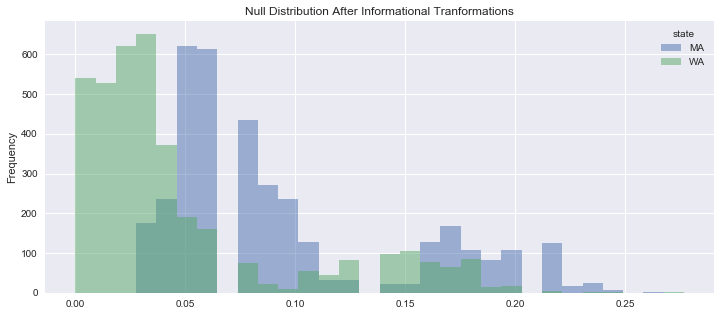

In [298]:
analysis.null_row_listingdist(
    bins=30, title='Null Distribution After Informational Tranformations')

#### Informational Feature Transformation Results

These informational columns are not substantially correlated with price. For this reason, they will be removed from the dataset, with the exception of **house_rules** or **interaction**. They have the biggest correlation with price. However, they are also heavily correlated with each other. For this reason, we are going to pick just **house_rules** because it has the highest correlation with price.

We are also removing description since it had no nulls and by itself it provides no value given that the columns have too much categories of text.

We now have less row nulls than before. It is looking much cleaner.

In [299]:
def func_drop_transform(column_list):
    """
    Droping columns from listing without having to write the whole line.
    
    parameter
    ---------
    column_list : column list to removed.
    """
    listings_transform.drop(column_list, axis=1, inplace=True)

In [300]:
remove_cols = [x for x in inform_columns if x != 'house_rules']
func_drop_transform(remove_cols)

In [301]:
analysis.null_row_feature_status(percentages=True)

monthly_price                   0.675132
weekly_price                    0.608132
security_deposit                0.566662
jurisdiction_names              0.484263
has_availability                0.484263
neighbourhood_group_cleansed    0.484263
cleaning_fee                    0.288667
review_scores_accuracy          0.200054
review_scores_checkin           0.199649
review_scores_value             0.199514
review_scores_location          0.199514
review_scores_cleanliness       0.198703
review_scores_communication     0.198433
review_scores_rating            0.197217
last_review                     0.186816
reviews_per_month               0.186816
first_review                    0.186816
host_acceptance_rate            0.168040
host_response_time              0.134270
host_response_rate              0.134270
neighbourhood                   0.129542
medium_url                      0.124139
xl_picture_url                  0.124139
thumbnail_url                   0.124139
dtype: float64

### Assessing Dolar Value Features --C

In [302]:
# Preparing for tranformations
clean_func = lambda x: cleaning_dollar(x)
dollar_columns = listings_transform.columns.str.contains('fee|price|deposit|extra')
dollar_columns = listings_transform.columns[dollar_columns].tolist()

listings_transform.loc[:, dollar_columns] = listings_transform[
    dollar_columns].apply(clean_func)

#### Checking Correlations for Dollar Features

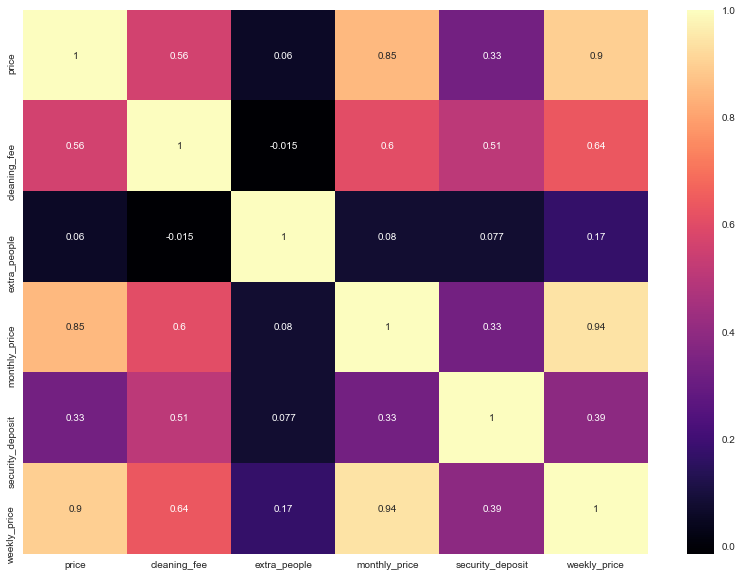

In [303]:
analysis = AnalysisStatus(calendar_complete, listings_transform)
analysis.correlation_heatmap(dollar_columns)

**Analysis**: We can see that monthly price is highly correlated with price. But these two variables are linking variables, which means that manipulating one will manipulate the other one dependently. Therefore, monthly_price is not independent. We must remove it. The same applies to weekly_price.

So there is no use for using monthly_price and weekly_price to predict price because that is a bit redundant--no wonder they are heavily correlated. However, cleaning_fee and security_deposit are the main drivers of the listing price. Thus, we are dropping listing price derived features and keeping the fees, which are additions to the price.

The null rows are mostly clean at this time. We are doing a bit more cleaning, and we will be done.

In [304]:
drop_dollarder = ['monthly_price', 'weekly_price']
func_drop_transform(drop_dollarder)

#### Imputations of Zero Fees and Deposits

In [305]:
fee_columns = ['cleaning_fee', 'security_deposit']
listings_transform.loc[:, fee_columns] = listings_transform[fee_columns].fillna(0)

#### Checking Null Distributions After Removal of Pricing Derived Features and Imputations

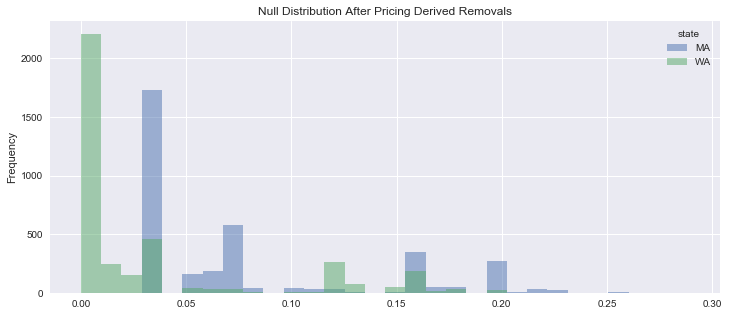

In [306]:
analysis.null_row_listingdist(
    bins=30, title='Null Distribution After Pricing Derived Removals')

*It is looking very clean now. But we still have more work to do--more cleaning.

In [307]:
analysis.null_row_feature_status(percentages=True)

has_availability                0.484263
jurisdiction_names              0.484263
neighbourhood_group_cleansed    0.484263
review_scores_accuracy          0.200054
review_scores_checkin           0.199649
review_scores_value             0.199514
review_scores_location          0.199514
review_scores_cleanliness       0.198703
review_scores_communication     0.198433
review_scores_rating            0.197217
first_review                    0.186816
reviews_per_month               0.186816
last_review                     0.186816
host_acceptance_rate            0.168040
host_response_time              0.134270
host_response_rate              0.134270
neighbourhood                   0.129542
medium_url                      0.124139
thumbnail_url                   0.124139
xl_picture_url                  0.124139
dtype: float64

### Assessing Missing Geographical Features

#### 5 Sample Rows of Geographical Columns

In [308]:
# Geo with nulls
geo_null_cololumns = [
    'jurisdiction_names', 'neighbourhood_group_cleansed', 'neighbourhood',
    'host_neighbourhood', 'host_location', 'city'
]

# Geo complete
geo_comp_columns = ['state', 'street']

listings_transform[geo_null_cololumns + geo_comp_columns].sample(5)

,jurisdiction_names,neighbourhood_group_cleansed,neighbourhood,host_neighbourhood,host_location,city,state,street
3649,WASHINGTON,Queen Anne,Queen Anne,Queen Anne,"Seattle, Washington, United States",Seattle,WA,"5th Avenue West, Seattle, WA 98119, United States"
32,NaN,NaN,Roslindale,Roslindale,"Boston, Massachusetts, United States",Boston,MA,"Conway Street, Boston, MA 02131, United States"
4631,WASHINGTON,Central Area,Atlantic,Atlantic,"Seattle, Washington, United States",Seattle,WA,"South Jackson Street, Seattle, WA 98144, Unite..."
126,NaN,NaN,Jamaica Plain,Jamaica Plain,"Boston, Massachusetts, United States",Boston,MA,"Creighton Street, Boston, MA 02130, United States"
6863,WASHINGTON,Other neighborhoods,Bitter Lake,Bitter Lake,"Seattle, Washington, United States",Seattle,WA,"Whitman Avenue North, Seattle, WA 98133, Unite..."


#### Jurisdiction and State

In [309]:
listings_transform.fillna('missing').groupby(['state', 'jurisdiction_names']).size()

state  jurisdiction_names
MA     missing               3585
WA     WASHINGTON            3817
wa     WASHINGTON               1
dtype: int64

#### Neighbourhood Features

In [310]:
match_func = lambda x: x.neighbourhood == x.host_neighbourhood
listings_transform[[
    "neighbourhood_group_cleansed", "neighbourhood", "host_neighbourhood",
    "host_location", "neighbourhood_cleansed"
]].astype(str).assign(match=match_func).query("match==False").sample(5)

,neighbourhood_group_cleansed,neighbourhood,host_neighbourhood,host_location,neighbourhood_cleansed,match
5045,Downtown,nan,Belltown,"Seattle, Washington, United States",Central Business District,False
2199,nan,Fenway/Kenmore,Back Bay,US,Fenway,False
4377,University District,University District,Ravenna,"Seattle, Washington, United States",University District,False
1865,nan,nan,South End,"Boston, Massachusetts, United States",Beacon Hill,False
3018,nan,nan,Allston-Brighton,"Boston, Massachusetts, United States",Dorchester,False


#### Missing City

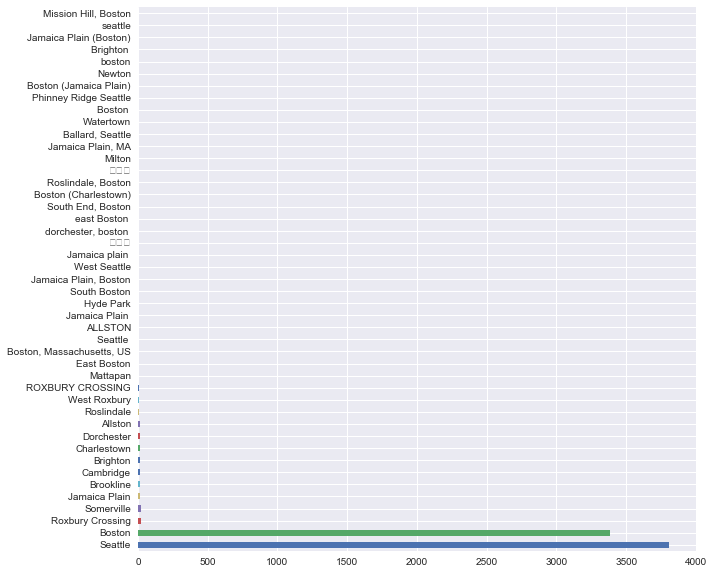

In [311]:
# Checking sparsity
listings_transform.city.value_counts().plot.barh(figsize=(10, 10));

#### Grouping Sparse Classes for City

In [312]:
# Fixing sparsity issue
eng_group_bos = {True:'Boston'}
eng_group_sea = {True:'Seattle'}
eng_group_city = lambda x: x.str.contains('Boston|Seattle')

# Grouping Seattle Areas
fill_sea = listings_transform.city.str.contains('seattle', case=False)\
    .map(eng_group_sea)

# Grouping Boston Areas
fill_bos = listings_transform.city.str.contains('boston', case=False)\
    .map(eng_group_bos)

# Grouping Other Areas
group_sparse = fill_bos.fillna(fill_sea).where(eng_group_city, 'Other')

# Applying sparcity fix to city
listings_transform.loc[:, 'city'] = group_sparse

,city
Seattle,51.56%
Boston,45.93%
Other,2.51%


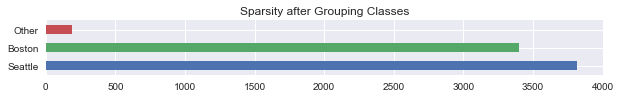

In [313]:
# Plotting sparsity
listings_transform.city.value_counts().plot.barh(
    figsize=(10, 1), title='Sparsity after Grouping Classes')

# Checking sparsity
(listings_transform.city.value_counts()/listings_transform.city.count())\
    .to_frame().style.format("{:2.2%}")

####  Geographical Features Results

We found that **jurisdiction_names** are related identically to state and are completely missing for Massachusetts. Thus we are removing it. Also **neighbourhood_group_cleansed** has too many missing values to map with zipcodes to extract the neighborhood. We could get a dataset to map this. But for now, we will just remove it. There are some free zip code databases online that we can use to extract these. However, although **neighbourhood** has some duplicates and the process to extract those using zipcodes is not set yet. We are keeping this feature as predictor and converting the nulls to dummies.

We are removing **jurisdiction_names, neighbourhood_group_cleansed, and neighbourhood** from the listings and adding them to a tryout dataframe so we can pass it to the model for curiosity's sake. 

As for **city**, even though the nulls where insignificant, the sparsity of city groups were more concentrated in Boston and Seattle. We can use this feature but we need to group these sparse classes into other. However, some of these cities pertains to Boston, so we will need to map those.

In [314]:
drop_columns = ['jurisdiction_names', 'neighbourhood_group_cleansed', 'neighbourhood']
tryout = listings_transform[drop_columns]
func_drop_transform(drop_columns)

In [315]:
analysis.null_row_feature_status(percentages=True)

has_availability               0.484263
review_scores_accuracy         0.200054
review_scores_checkin          0.199649
review_scores_value            0.199514
review_scores_location         0.199514
review_scores_cleanliness      0.198703
review_scores_communication    0.198433
review_scores_rating           0.197217
reviews_per_month              0.186816
last_review                    0.186816
first_review                   0.186816
host_acceptance_rate           0.168040
host_response_time             0.134270
host_response_rate             0.134270
medium_url                     0.124139
thumbnail_url                  0.124139
xl_picture_url                 0.124139
dtype: float64

#### Assessing Has Availability Feature

In [316]:
# number of zero prices
listings_transform.query("has_availability!=has_availability").price.where(
    lambda x: x == 0).dropna()

Series([], Name: price, dtype: float64)

As we know available listings have prices. All listings have prices in the listings dataset. Therefore, has_availability should all be True. In this case, this feature provides no value to the model, and we will remove it.

In [317]:
func_drop_transform('has_availability')

### Assessing Reviews

#### Reviews where Number of Reviews where not Zero

In [318]:
# Columns related to reviews
review_columns = listings_transform.columns[
    listings_transform.columns.str.contains('review')]
review_columns = ['id'] + review_columns.tolist()

listings_transform[review_columns].query(
    "number_of_reviews!=0").isnull().sum().to_frame('missing')

,missing
id,0
first_review,0
last_review,0
number_of_reviews,0
review_scores_accuracy,98
review_scores_checkin,95
review_scores_cleanliness,88
review_scores_communication,86
review_scores_location,94
review_scores_rating,77


*Where numer of reviews are not zero there are minimal null values that can be drop from the model, or just converted to the median rating for now.

#### Reviews where Number of Reviews where Zero

In [319]:
listings_transform[review_columns].query("number_of_reviews==0").isnull().sum(
).to_frame('missing')

,missing
id,0
first_review,1383
last_review,1383
number_of_reviews,0
review_scores_accuracy,1383
review_scores_checkin,1383
review_scores_cleanliness,1383
review_scores_communication,1383
review_scores_location,1383
review_scores_rating,1383


*All of these values have a meaning of no rating provided. Therefore, we should not remove any of these. Perhaps, what we can do is create another feature stating that the zero provided is actually a non provided field istead of an actual zero rating. The new feature will be called non_provided_rating.

#### Reviews where Number of Reviews where not Zero Including Reviews Dataset Merge

In [320]:
listings_transform[review_columns].query("number_of_reviews!=0").merge(
    reviews.groupby('listing_id', as_index=False).sum(),
    left_on='id',
    right_on='listing_id',
    how='left',
    suffixes=['', '_reviews']).isnull().sum().to_frame('missing')

,missing
id,0
first_review,0
last_review,0
number_of_reviews,0
review_scores_accuracy,98
review_scores_checkin,95
review_scores_cleanliness,88
review_scores_communication,86
review_scores_location,94
review_scores_rating,77


*There are comment that we could use to extract ratings using NLP. However, the extra work might not provide us the accuracy that we deserve given that there is so few missing ratings.

In [321]:
non_provided = listings_transform.filter(regex='score|review').drop(
    'number_of_reviews', axis=1).isnull().sum(axis=1)

non_provided.describe()

count    7403.000000
mean        1.953532
std         3.928502
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
dtype: float64

*The null reviews are for a whole row of ratings per specific listings. We can see that all rows have either 10 null rows or 0 rows nulls for specific listings.

In [322]:
review_col = listings_transform.filter(regex='score|review').drop(
    'number_of_reviews', axis=1).columns.tolist()

listings_transform = listings_transform.assign(
    non_provided_rating=non_provided.map({0:0, 10:1}))

In [323]:
listings_transform.loc[:, review_col] = listings_transform[review_col].fillna(0)

In [324]:
listings_transform[review_columns].query("number_of_reviews==0").isnull().sum(
).to_frame('missing')

,missing
id,0
first_review,0
last_review,0
number_of_reviews,0
review_scores_accuracy,0
review_scores_checkin,0
review_scores_cleanliness,0
review_scores_communication,0
review_scores_location,0
review_scores_rating,0


In [325]:
listings_transform[review_columns +
                   ['non_provided_rating']].query("first_review!=0")[[
                       'first_review', 'non_provided_rating'
                   ]].sample(3)

,first_review,non_provided_rating
837,2015-11-16,0.0
7256,2015-08-12,NaN
4674,2015-09-11,0.0


In [326]:
listings_transform[review_columns +
                   ['non_provided_rating']].query("first_review==0")[[
                       'first_review', 'non_provided_rating'
                   ]].sample(3)

,first_review,non_provided_rating
5546,0,1.0
3673,0,1.0
2494,0,1.0


*The transformation worked. Let's see the correlation of it.

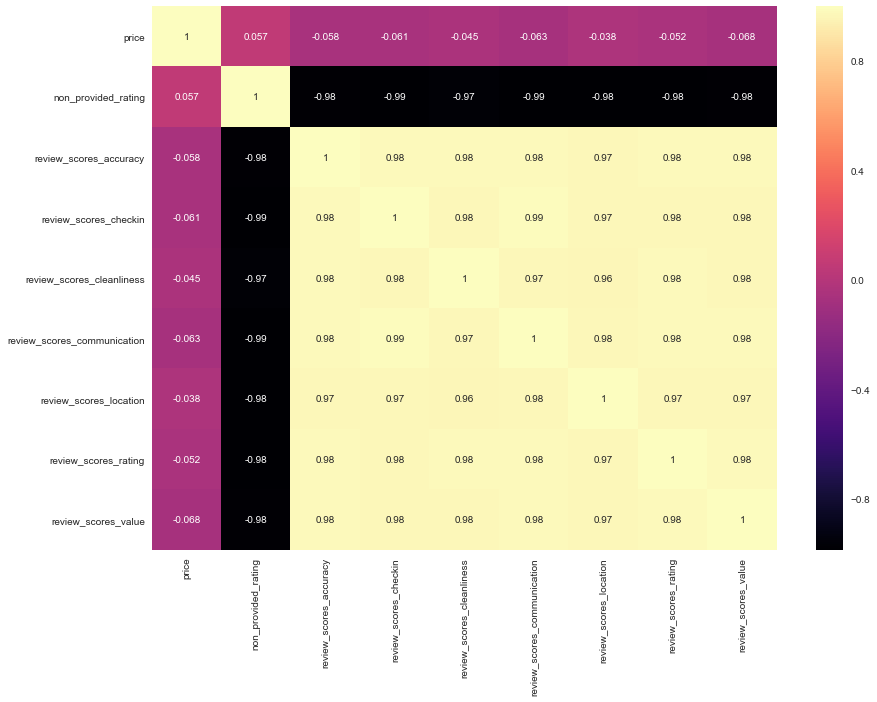

In [327]:
analysis = AnalysisStatus(calendar_complete, listings_transform)
score_col = listings_transform.filter(regex='score').columns.tolist()
analysis.correlation_heatmap(['non_provided_rating'] + score_col)

**Analysis**: We can see that scores bring no value to the model. Therefore, we will remove all of these fields.

In [328]:
func_drop_transform(score_col)

####  **Engineering review_lag and review_rate** --E

In [329]:
checkpoint = listings_transform.copy()

In [340]:
listings_transform = checkpoint.copy()

In [341]:
# creating the lag between first and last review
day_func = lambda x: x.days
diff_func = lambda x: (pd.to_datetime(x.last_review) - pd.to_datetime(
    x.first_review)).apply(day_func)
reate_func = lambda x: (x.review_lag / x.number_of_reviews)

# engineering review lag
listings_transform = listings_transform.assign(review_lag=diff_func)

# engineering review rate
listings_transform = listings_transform.assign(review_rate=reate_func)

# dropping fist_review and last_review
review_dates = ['first_review', 'last_review']
listings_transform.drop(review_dates, axis=1, inplace=True)

In [ ]:
# Zero for no review provided
listings_transform.loc[:, 'review_rate'] = listings_transform.review_rate.fillna(0)

In [ ]:
analysis = AnalysisStatus(calendar_complete, listings_transform)
analysis.correlation_heatmap(
    ['review_lag', 'review_rate', 'number_of_reviews', 'reviews_per_month'] +
    ['non_provided_rating'])

In [ ]:
analysis = AnalysisStatus(calendar_complete, listings_transform)
analysis.correlation_heatmap(
    ['review_lag', 'review_rate', 'number_of_reviews', 'reviews_per_month'] +
    ['non_provided_rating'])

**Analysis**: We are removing **first_review** and **last_review** and replacing it with **review_lag** to account for the dates between the first review and the last review. We are also engineering the rate of reviews by dividing the **review_lag** by the **number_of_reviews**, this is the **review_rate**. But we can see that the review_lab provided no value to the model. So we will remove. However, the review_rate, which was engineered from review_flag and number_of_reviews ended up having more value than its derived features. Thus, we are removing number_of_reviews because it was use to create review_rate.

Also, the newly created feature **non_provided_rating** adds no value to the model. So we will remove it too.

**Engineering Description**:
* For the lag, we subtracted the first review date from the last review date.
* For the review rate, we divided the review lag by the number of reviews, which give us the rate of reviews between the first review date and the last review date.

We can see that the only valuable engineered feature is the **review_rate**. The **review_lag** is insignificant. And the initial feature number of reviews is insignificant by itself. The review rate at least has a low significance with price.

In [182]:
func_drop_transform([
    'review_lag', 'number_of_reviews',
    'non_provided_rating'
])

### **Removing Other Irrelevant Features** --RC

In [195]:
irrelevant_columns.remove('host_about')

In [196]:
irrelevant_columns

['host_has_profile_pic',
 'host_picture_url',
 'host_thumbnail_url',
 'host_url',
 'jurisdiction_names',
 'listing_url',
 'medium_url',
 'name',
 'picture_url',
 'require_guest_profile_picture',
 'thumbnail_url',
 'xl_picture_url',
 'host_name']

In [197]:
possible_columns = ['host_has_profile_pic', 'require_guest_profile_picture']
drop_columns = [
    i for i in irrelevant_columns
    if i not in possible_columns + ['jurisdiction_names']
]

In [198]:
func_drop_transform(drop_columns)

In [199]:
analysis.null_row_feature_status(percentages=True)

review_rate             0.186816
host_acceptance_rate    0.168040
host_response_time      0.134270
host_response_rate      0.134270
dtype: float64

We ended up removing all irrelevant features except for  the picture related columns, which could be benefetial to the model.

### Assessing Nulls at the Row Level

In [ ]:
analysis.null_row_listingdist(30, 'Null at Row Level After All Removals')

In [ ]:
(pd.cut(
    listings_transform.row_null_pct, bins=np.arange(0, 1, .03),
    right=False).value_counts() / listings_transform.shape[0]
 ).where(lambda x: x > 0).dropna().to_frame("Removal%").reset_index().rename(
     columns={'index': 'Null at Row'})

As we can see now, the number of nulls at the row level is very low. At this time we are going to remove anything with 12% of nulls at the row level. It will preserve 73% of the data for analysis.

### Splitting, Engineering, and Removing amenities and host_verifications --E RC

In [ ]:
# Instantiationg encoder
ds = DummySplit(listings_transform)

# Original example
listings_transform[['amenities']].head()

In [ ]:
# split add and drop -- save columns and example of transformations
ds.split_create_dummy('amenities')
ds.add_dummies(drop_original=True)
amenities_columns = ds.dummy_columns[:]
ds.dummy_frame.head()

In [ ]:
# Original example
listings_transform[['host_verifications']].head()

In [ ]:
# split add and drop -- save columns and example of transformations
ds.split_create_dummy(feature_name='host_verifications')
ds.add_dummies(drop_original=True)
host_verifications = ds.dummy_columns[:]
ds.dummy_frame.head()

In [ ]:
# release memory
del ds

#### Checking Correlation of New Features

In [ ]:
analysis.listings = listings_transform
analysis._merge()

In [ ]:
analysis.correlation_heatmap(amenities_columns, show_values=False)

In [ ]:
scope = ['AirConditioning', 'FamilyKidFriendly', 'CableTV', 'TV', 'ElevatorinBuilding']
analysis.correlation_heatmap(scope, show_values=True)

In [ ]:
analysis.correlation_heatmap(host_verifications, show_values=True)

#### Amenities and Host Verification Results

In the amenities we found that some features stand out with moderate correlations--AirConditioning, FamilyKidFriendly, CableTV, TV, and ElevatorinBuilding were some of them. These features will add values to the model. However, they are a slightly correlated with each other, except for FamilyKidFriendly and ElevatorinBuilding.

On the contrary, host_verividations did not have any valuable features extracted, except for amex, which scored a $r$ of .10. Perhaps, we can add it to the model at the end.

We are adding to the model the highest correlated features that have the lowest multicollinearity with each other.

### Final Transformations and Removals

#### **Removing Irrelevant Columns** -- RC

In [ ]:
removals = [
    'calendar_updated', 'experiences_offered', 'is_location_exact',
    'rowsource', 'zipcode', 'street', 'host_location', 'smart_location',
    'host_neighbourhood', 'neighbourhood_cleansed', 'country', 'country_code',
    'scrape_id'
]

listings_transform.drop(removals, axis=1, inplace=True)

#### **Cleaning Percentages** -- C

In [ ]:
cleaning = ['host_acceptance_rate', 'host_response_rate']
listings_transform.loc[:, 'host_acceptance_rate'] = cleaning_percent(
    listings_transform.host_acceptance_rate)

listings_transform.host_acceptance_rate.head()

In [ ]:
listings_transform.loc[:, 'host_response_rate'] = cleaning_percent(
    listings_transform.host_response_rate)

listings_transform.host_response_rate.head()

#### Transformations of t/f Values

In [ ]:
transform = [
    'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost',
    'instant_bookable', 'require_guest_phone_verification', 'requires_license',
    'require_guest_profile_picture', 'longitude', 'latitude'
]

listings_transform.loc[:, transform] = listings_transform[transform].apply(
    lambda x: x.map({
        'f': 1,
        't': 0
    }))

listings_transform[transform].head()

#### **Engieneering host_lifetime from  host_since and calendar_updated** -- E

In [ ]:
engieneering = ['host_since', 'calendar_last_scraped']

# Engineering feature by subracting
host_lifetime = listings_transform.calendar_last_scraped.apply(
    pd.to_datetime) - listings_transform.host_since.apply(pd.to_datetime)

# Extracting date number
host_lifetime = host_lifetime.apply(lambda x: x.days)

# Deleting original from dataset
listings_transform.drop(engieneering, axis=1, inplace=True)

# Adding engineered feature to dataset
listings_transform['host_lifetime'] = host_lifetime

In [ ]:
analysis.listings = listings_transform
analysis._merge()

In [ ]:
analysis.correlation_heatmap(['host_lifetime'])

#### Listings Engineered Feature Results

 A correlation of .1 is a small correlation. However, it could be beneficial to the model by a small margin. We will test the model with the highest correlated features first and will add some like this one to it to attempt to improve its scores.

## One-Hot Encoder

# CHECKPOINT

In [ ]:
frame_holder = listings_transform.copy()

In [ ]:
listings_transform = frame_holder.copy()

### Applying Encoder to Categorical

In [ ]:
# Saving Categorical for further analysis
df_categorical = listings_transform.select_dtypes(include=object)

# Example of categorical
df_categorical.sample(2).T

### Applying One-Hot Encoder

In [ ]:
# Initiating Encoder
encoder = OneHotEncoder()

# Get only columns with categories
listings_object = listings_transform.select_dtypes(
    include=object)

# Get list of removal columns
remove_original = listings_object.columns.tolist()

# Fitting and tranforming categories
# Fill nulls with missing to create missing dummy
X_encoded = encoder.fit_transform(listings_object.astype(str))

# Remove original encoded columns
listings_transform.drop(remove_original, axis=1, inplace=True)

# Encoded coluns
columns_encoded = encoder.categories_

# Extracting from list of list
dummy_columns = []
for original, enc_col in list(zip(remove_original, columns_encoded)):
    for dummy in enc_col:
        dummy_columns.append(re.sub('\W', '', (original + '_' + dummy)))

# Creating dataframe
X_encoded = pd.DataFrame(X_encoded.toarray(), columns=dummy_columns)

# Applying listings 
listings_encoded = pd.concat([listings_transform, X_encoded], axis=1)

## Correlation Analysis

In [ ]:
def refresh_analysis_encoded():
    """
    Re-runs the analysis class and updates its dataframe objects.
    It prepares for correlation status.
    """
    analysis.listings = listings_encoded
    analysis._merge()

In [ ]:
def drop_get_dummies(drop_list):
    """
    Drop dummies from transformed listings, refreshes the analysis, and
    updates the dummy_columns variable to use in correlation map.
    
    parameter
    ---------
    drop_list : the list of dummy features to drop from the analysis
    """
    global dummy_columns
    analysis.df_merged.drop(drop_list, axis=1, inplace=True)
    # refresh_analysis_encoded()
    dummy_columns = [x for x in dummy_columns if x not in drop_list]

def get_dummy_from_feature(feature_name):
    """
    Extracts the dummies relative to the feature from which it was created.
    
    parameter
    ---------
    feature_name : the feature to extract dummies from the trasformed listings
    """
    return [x for x in dummy_columns if feature_name in x]

In [ ]:
refresh_analysis_encoded()

### Finding Perfect Multicollinearity

In [ ]:
analysis.coliniearity_table(include_perfect=True)

#### Removing Ids

In [ ]:
drop_get_dummies(['id', 'listing_id'])

#### Market Vs. State Correlations with Price

In [ ]:
# Get target dummies
market_dummies = df_categorical.market.astype(
    str).apply(lambda x: 'market_' + re.sub('\W', '', x)).unique().tolist()

# Show correlation of target dummies only
# Adding State
analysis.correlation_heatmap(market_dummies + ['state_MA', 'state_WA'], show_values=True)

In [ ]:
df_categorical.market.value_counts()

We can see there are some correlated fields. However, San Fransisco market stands out as having no correlation. Hence, there is low sparsity in San Fransisco.

Since markets other than Boston and Seattle are not well correlated with price, we are going to just drop market. Boston and Seattle markets are fully correlated with its state as it should. Thus, we are using state as a predictor instead of market.

Another interesting finding is state perfect multicollinearity. This means that I just can drop one of them and rename the other one state: 1 for Boston and 0 for Seattle

In [ ]:
drop_get_dummies(market_dummies)

#### Making State One Dummy

In [ ]:
# Droping Washington from state
drop_get_dummies(['state_WA'])

# Changing name
analysis.df_merged.rename(columns={'state_MA':'stateMApWAn'}, inplace=True)

In [ ]:
analysis.df_merged.stateMApWAn.value_counts()

#### Fixing Host Listing Count Multicollinearity

In [ ]:
analysis.correlation_heatmap(['host_listings_count', 'host_total_listings_count'])

It does not matter wich one we remove, they are both correlated the same way with calendar listing price.

In [ ]:
drop_get_dummies(['host_total_listings_count'])

### Finding High Multicollinearity

In [ ]:
analysis.coliniearity_table(multi_r=.8)

#### Interaction Vs. Access

In [ ]:
analysis.correlation_heatmap(['interaction', 'access'])

In [ ]:
listings[['interaction', 'access']].head(10)

It seems that host tend to write an interaction message concurrently with an access message. However, the access messages have an insignificant relationship with calendar listing price. We will drop access from the model.

In [ ]:
drop_get_dummies('access')

#### Availability Features

In [ ]:
available_cond = analysis.df_merged.columns.str.contains('avail')
available_col = analysis.df_merged.columns[available_cond].tolist()
analysis.correlation_heatmap(available_col)

All availability features are correlated with each other, except for availability_365. It has an insignificant correlation with price. Thus, we are removing it. The other 3 (availability_30, availability_60, and availability_90) may be all calculated features and therefore multicorrelated because of it. Base on the correlation with calendar listing price, we are keeping only the **availability_60**.

In [ ]:
remove_cols = [x for x in available_col if x != 'availability_60' ]
remove_cols

drop_get_dummies(remove_cols)

#### Bed Vs. Accommodates

In [ ]:
analysis.correlation_heatmap(['beds', 'accommodates'])

We see a high indication of multicollinearity with beds and accommodates. It make sense to think that a listing with more beds accommodates more people. However, accommodates have more corellation with calendar listing price than beds. For this reason, we are removing beds from the model.

In [ ]:
drop_get_dummies('beds')

#### Host Listings Vs. Calculated Host Listings

In [ ]:
analysis.correlation_heatmap(['host_listings_count', 'calculated_host_listings_count'])

Giving that host_listings is heavily correlated with its calculated counterpart, we are keeping only the feature most correlated with calendar listing price, which is **host_listings**.

In [ ]:
drop_get_dummies('calculated_host_listings_count')

#### Removing Price in Listing Dataset

No need to analyize this. It is obvious that last sccraped price in listing will be slighly correlated with calendar listing price.

In [ ]:
drop_get_dummies('price_listing')

#### Internet and WirelessInternet Combination

In [ ]:
analysis.correlation_heatmap(['Internet', 'WirelessInternet'])

They have almost the same correlation. However, removing one of them might create some bias since they mean exactly the same thing. Instead of removing it, we are just combining them into one.

The methodology is summing both dummies. If the sum is two, then both have an internet indicator and the 2 should be substitute to 1. If the sum is 1, then at least one have an internet indicator--we keep the indicator as 1. If the sum is 0, then none of them have an internet indicator--we keep the indicator as 0. 

In [ ]:
print("This is the original shape of the model data", analysis.df_merged.shape)

In [ ]:
where_is_zero = analysis.df_merged[['Internet', 'WirelessInternet'
                    ]].eval("Internet+WirelessInternet==0")

In [ ]:
where_is_one = analysis.df_merged[['Internet', 'WirelessInternet'
                    ]].sum(axis=1).where(lambda x: x != 2).fillna(1)

In [ ]:
# The sum where the sum of both is zero
# Plus the sum of both of them being greater than zero
# Should equal the shape of the original data shape to validate transformation
print("This is the total validation of the transformation", 
      where_is_zero.sum() + where_is_one.sum(), "It is validated")

In [ ]:
drop_get_dummies('WirelessInternet')

In [ ]:
analysis.df_merged.loc[:, 'Internet'] = where_is_one

#### Iron and HairDryer Combination

In [ ]:
analysis.correlation_heatmap(['Iron', 'HairDryer'])

Since these two dummy variables most likely are offered one without the other, they have a high multicollinearity. However, we could engineer a new feture called iron_hairdryer to see if it performs better than the individual ones.

The methodology of the new feature (iron_hairdryer) is if the sum of both is 2, then they provided both iron and hari dryer--we set it to 1. If the sum is not 2, then they did not provided the combo and therefore is set to 0.

In [ ]:
combination_ind = analysis.df_merged[['Iron', 'HairDryer']].sum(axis=1).map({
    2:
    1
}).fillna(0)

In [ ]:
analysis.df_merged.loc[:, 'iron_hairdryer'] = combination_ind

In [ ]:
analysis.correlation_heatmap(['Iron', 'HairDryer', 'iron_hairdryer'])

As expected, the combination of both increase the correlation with calendar listing price. Therefore, we are removing the original features and leaving the engineered feature.

In [ ]:
drop_get_dummies(['Iron', 'HairDryer'])

### City Vs. State

In [ ]:
analysis.correlation_heatmap(['city_Seattle', 'city_Boston', 'stateMApWAn'])

We have the same causal multicollinearity than state vs. market since one is the parent of the other. Since we have converted state already, we are keeping state, even though Boston city has more correlation.

In [ ]:
drop_get_dummies(['city_Seattle', 'city_Boston'])

### Private Room, Apartment, Entire Home, and House

In [ ]:
analysis.coliniearity_table(multi_r=.8)

Given that the last of the multicollinearity don't seem to be causal in nature. We are keeping these features as they are in the model.

### Variance Inflation Factor (VIF)

In [ ]:


df = pd.DataFrame(
    {'a': [1, 1, 2, 3, 4],
     'b': [2, 2, 3, 2, 1],
     'c': [4, 6, 7, 8, 9],
     'd': [4, 3, 4, 5, 4]}
)

display(df)

X = add_constant(df)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

In [ ]:
X = add_constant(analysis.df_merged)

In [ ]:
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

#### Full Correlation of Encoded Categories

In [ ]:
analysis.correlation_status(dummy_columns, show_values=False)

#### City Vs. State Correlations with Price

In [ ]:
city = get_dummy_from_feature('city')
state = get_dummy_from_feature('state')

In [ ]:
analysis.correlation_status(city + state, show_values=True)

The same issue of multicollinearity happens here. City is obviously correlated with state. However, other cities don't add value to the model. Thus, we want to keep the simplest one that give us the more correlation: state. 

In [ ]:
drop_get_dummies(city)

In [ ]:
analysis.correlation_status(dummy_columns, show_values=False)

#### Property Type Vs. Room Type

In [ ]:
room_type = get_dummy_from_feature('room_type')
property_type = get_dummy_from_feature('property_type')

In [ ]:
analysis.correlation_status(room_type + property_type, show_values=False)

In [ ]:
df_categorical.property_type.value_counts()

In [ ]:
# Property type columns to transform excluding 
tran_col = df_categorical.property_type.value_counts().where(
    lambda x: x < 1000).dropna().index.tolist()

# Converting to encoded dummy naming
tran_col = ['property_type_' + re.sub("\W", '', x) for x in tran_col]

# Compacting target dummies into one dummy of 0 and 1
listings_transform['property_type_other'] = listings_transform[tran_col].sum(axis=1)

# Dropping original columns
drop_get_dummies(tran_col)

In [ ]:
reaply_analysis()

In [ ]:
property_type = [x for x in property_type if x not in tran_col]
analysis.correlation_status(room_type + property_type + ['property_type_other'], show_values=True)

House and apartment have multicollinearity and the highst correlationg goes to house. Therefore, we are removing apartment from property_type. 

Private room and entire home are correlated as well. But entire apartment is the biggest. So we are removing private room.

The rest looks ok. But by the way we are removing the dummy nulls and the grouped property type other. They give no value to the model.

In [ ]:
drop_columns = ['property_type_Apartment', 'room_type_Privateroom', 'property_type_other']
drop_get_dummies(drop_columns)

#### Rest of Correlations by Category Features Left

In [ ]:
features_left = list(dict.fromkeys([x.split('_')[0] for x in dummy_columns]))

for feat in features_left:
    feat_dummy = [x for x in dummy_columns if feat in x]
    analysis.correlation_status(feat_dummy, show_values=True)

### Remove Final Nulls

In [ ]:
df_final = analysis.df_merged

In [ ]:
y = df_final.loc[:, 'price']

In [ ]:
X = df_final.drop('price', axis=1)

In [ ]:
drop_test_model = X.isnull().sum().where(lambda x: x!=0).dropna().index.tolist()

In [ ]:
X.drop(drop_test_model, axis=1, inplace=True)

In [ ]:
test_size = int(round(X.shape[0]*.20, 0))
train_size = X.shape[0] - test_size

print(test_size, train_size)

In [ ]:
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

# Modeling & Visualizations

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
predictions = lr.predict(X_test)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
r2_score(y_test, predictions)

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes = datasets.load_diabetes()


# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

# Evaluating Results

# Conclussion